In [12]:
%load_ext autoreload
%autoreload 2

import os,sys,warnings
import h5py, pandas
import numpy as np
np.seterr(invalid=['ignore','warn'][0])
np.set_printoptions(legacy='1.25')
import math,cmath,pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('default')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.titlesize'] = 20
mpl.rcParams['figure.figsize'] = [6.4*1.2,4.8*1.2]
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['lines.marker'] = 's'
mpl.rcParams['lines.linestyle'] = ''
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 12
mpl.rcParams['xtick.labelsize'] = mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['xtick.major.size'] = mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.top']=mpl.rcParams['ytick.right']=True
mpl.rcParams['xtick.direction']=mpl.rcParams['ytick.direction']='in'
mpl.rcParams['legend.fontsize'] = 24
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# mpl.rcParams.update({"axes.grid" : True})
import util as yu
yu.flag_fast=False

lat_a=0.1163
hbarc = 1/197.327
lat_aInv=1/(lat_a*hbarc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [73]:
path='/capstor/store/cscs/userlab/s1174/lyan/code/glwc2/project2/03_NpiScatteringWilson/dataPrepare/A15/data_aux/cfgs_CGWokringCPU'
with open(path,'r') as f:
    cfgs=f.read().splitlines()
    cfgs_CGWorking=cfgs.copy()

def symmetrize(dat):
    dat_bw=np.roll(np.flip(dat,axis=1),1,axis=1)
    return((dat[:,:,0]+dat[:,:,5]) - (dat_bw[:,:,10]+dat_bw[:,:,15]))/4

def symmetrizeP(dat):
    dat_bw=np.roll(np.flip(dat,axis=1),1,axis=1)
    return (dat+dat_bw)/2

path1='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15_multiMethod_Nsrc=50/data_merge/NpiScatteringWilson.h5'
path2='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15/data_merge/NpiScatteringWilson.h5'

np.set_printoptions(precision=1,suppress=True)
with h5py.File(path1) as f1, h5py.File(path2) as f2:
    cfgs_all=[cfg.decode() for cfg in f1['cfgs'][:]]
    cfgs_map=[cfgs_all.index(cfg) for cfg in cfgs]
    
    from random import shuffle
    cfgs_random=cfgs_all.copy()
    shuffle(cfgs_random)
    cfgs_random=cfgs_random[:-3]
    cfgs_random.sort()
    cfgs_map2=[cfgs_all.index(cfg) for cfg in cfgs_random]
    
    cp_dat=np.real(symmetrizeP(f1['data/P'][:,:,0]))
    cp=np.real(yu.jackknife(symmetrizeP(f1['data/P'][:,:,0])))
    cps=np.real(yu.jackknife(symmetrizeP(f1['data/P'][cfgs_map,:,0])))
    cps2=np.real(yu.jackknife(symmetrizeP(f1['data/P'][cfgs_map2,:,0])))
    
    tau=1
    def C2pt2meff(C2pt,totalT):
        tfunc_C=lambda m,t:np.exp(-m*t)+np.exp(-m*(totalT-t))
        t=C2pt # dim=time
        t=(np.roll(t,-tau,axis=0))/(t)
        t=np.array([yu.fsolve2(lambda m:((tfunc_C(m,xt+tau))/(tfunc_C(m,xt)))-ele, 0.0593) for xt,ele in enumerate(t)])
        return t
    func=lambda c2pt:C2pt2meff(c2pt,48)
    mp=yu.jackmap(func,cp)
    mps=yu.jackmap(func,cps)
    mps2=yu.jackmap(func,cps2)
    
    c1=np.real(yu.jackknife(symmetrize(f1['data/N'][:,:,16])))
    c2=np.real(yu.jackknife(symmetrize(f2['data/N'][:,:,16])))
    
    c1s=np.real(yu.jackknife(symmetrize(f1['data/N'][cfgs_map,:,16])))
    c2s=np.real(yu.jackknife(symmetrize(f2['data/N'][cfgs_map,:,16])))
    
    mean1,err1=yu.jackme(c1)
    mean2,err2=yu.jackme(c2)
    print((err1/err2)**2)
    
    # mean1,err1=yu.jackme(c1s)
    # mean2,err2=yu.jackme(c2s)
    # print((err1/err2)**2)
    
    func=lambda c:np.log(c/np.roll(c,-1))
    m1=yu.jackmap(func,c1)
    m2=yu.jackmap(func,c2)
    
    m1s=yu.jackmap(func,c1s)
    m2s=yu.jackmap(func,c2s)
    
    mean1,err1=yu.jackme(m1)
    mean2,err2=yu.jackme(m2)
    print((err1/err2)**2)

[13.   4.4  4.6  4.5  4.6  3.9  3.3  3.5  4.   4.6  4.8  5.1  6.9  7.4
  5.   3.8  4.3  4.7  4.9  3.2  3.   5.3  9.   8.  17.1 13.4  4.6  2.9
  1.6  3.5  7.5 24.2 23.9 10.1  6.6  4.3  4.5  3.   3.7  5.1  7.7  9.6
  5.6  6.   7.   6.5  6.1  5. ]
[  nan   5.9   5.4   7.    4.7   6.2   5.5   6.3   8.5   9.6   9.    7.1
   7.7   4.8   8.2  17.1  25.1  54.  429.1 420.3   nan   nan   nan   0.2
   nan   nan   nan   nan   nan   nan   nan   nan   0.1   0.    nan   0.
   1.    2.1   1.6   2.6   3.5   9.9   4.8   5.2   6.3   6.2   8.2   nan]


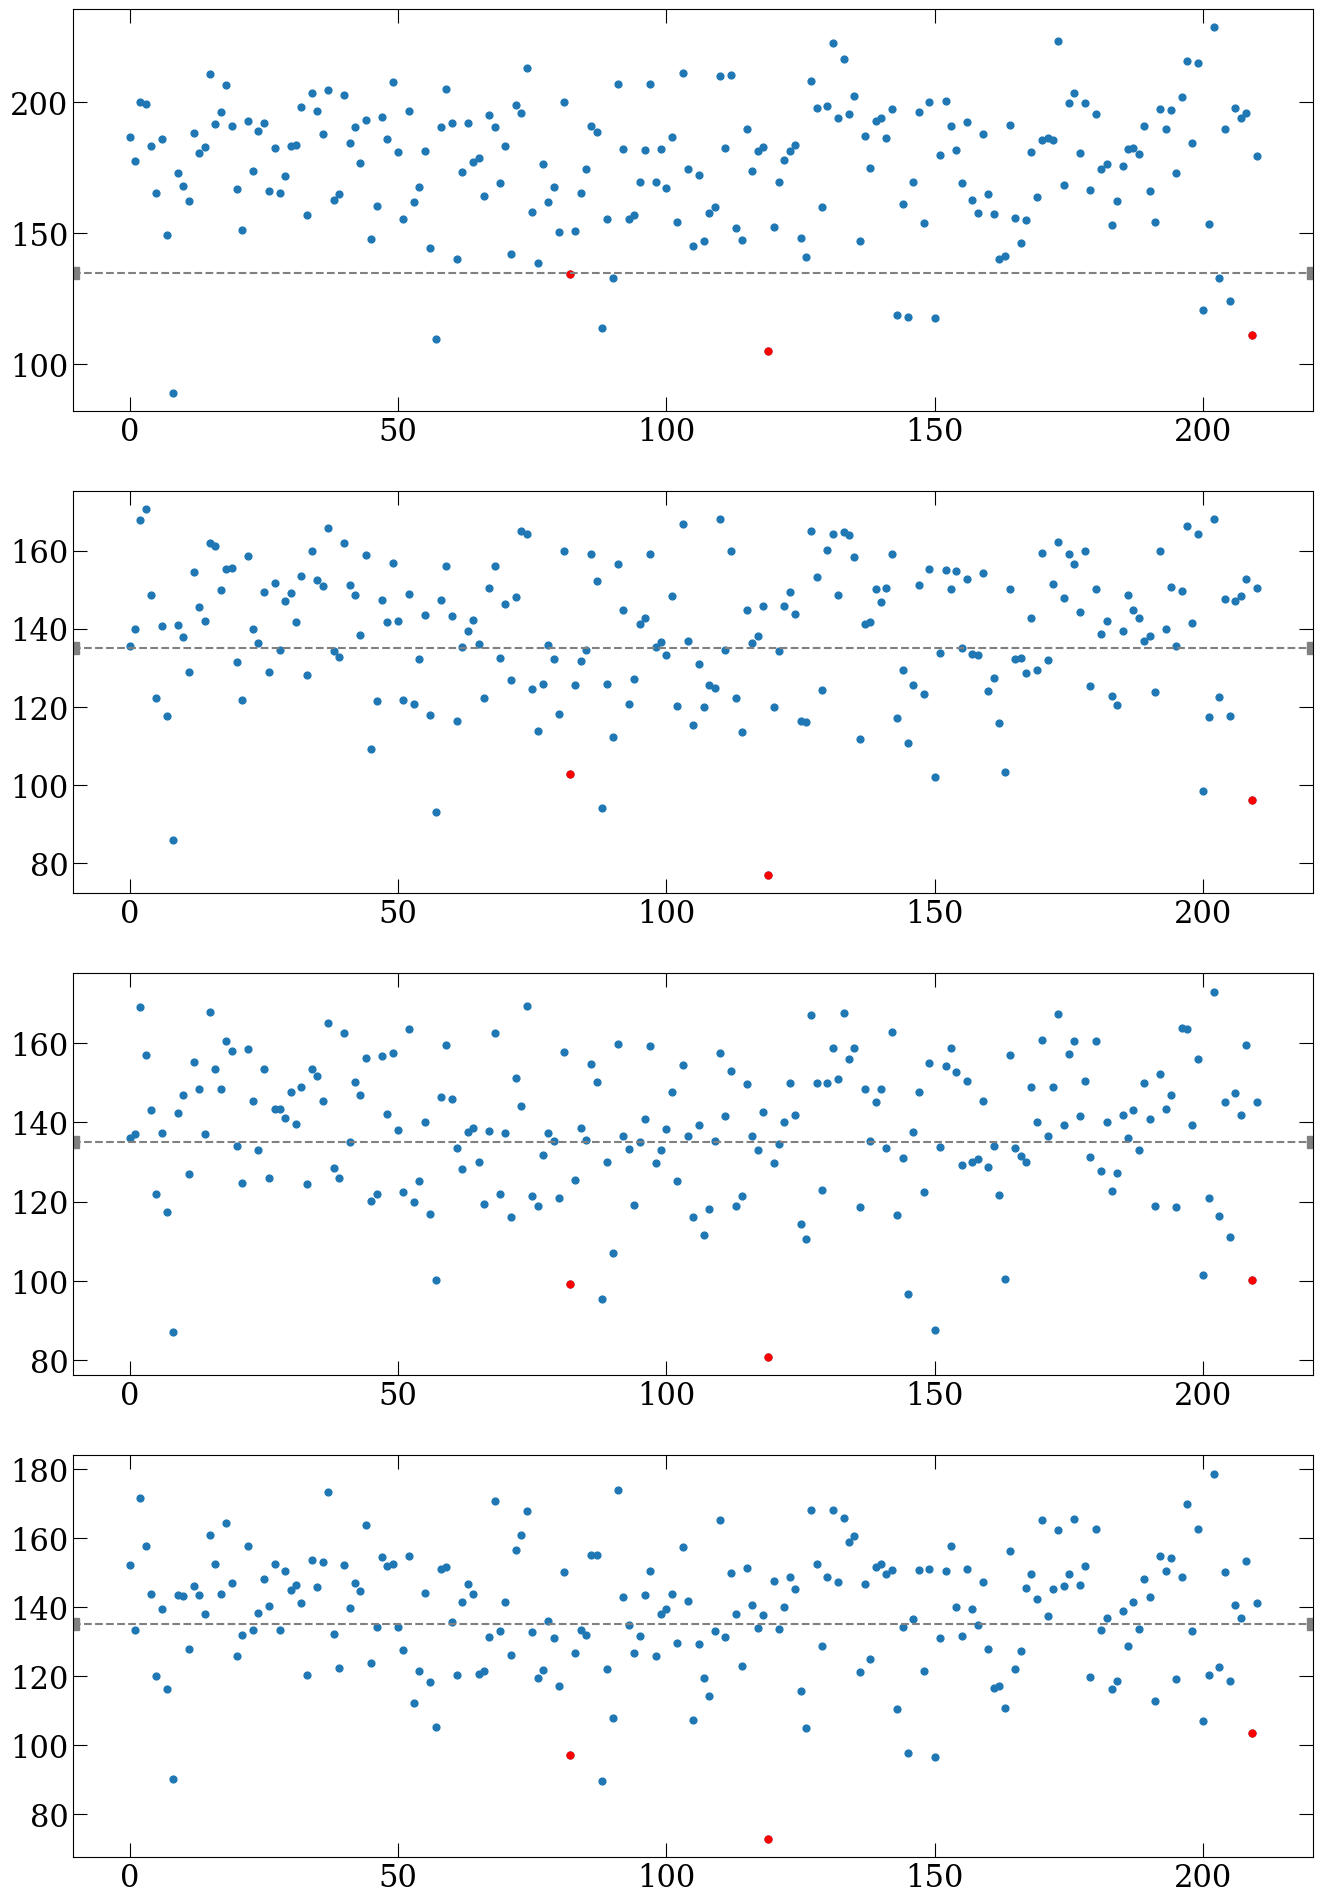

In [79]:
inds=[i for i,cfg in enumerate(cfgs_all) if cfg not in cfgs_CGWorking]

func=lambda c2pt:C2pt2meff(c2pt,48)
mp_dat=yu.jackmap(func,cp_dat)

tfs=[1,5,10,15]

fig, axs = yu.getFigAxs(len(tfs),1,Lrow=6,Lcol=16)

for i,tf in enumerate(tfs):
    ax=axs[i,0] 
    ax.axhline(135,color='grey',ls='--')
    
    ax.scatter(np.arange(len(mp_dat)),mp_dat[:,tf]*lat_aInv,s=24)
    ax.scatter(np.arange(len(mp_dat))[inds],mp_dat[inds,tf]*lat_aInv,color='r',s=24)

<ErrorbarContainer object of 3 artists>

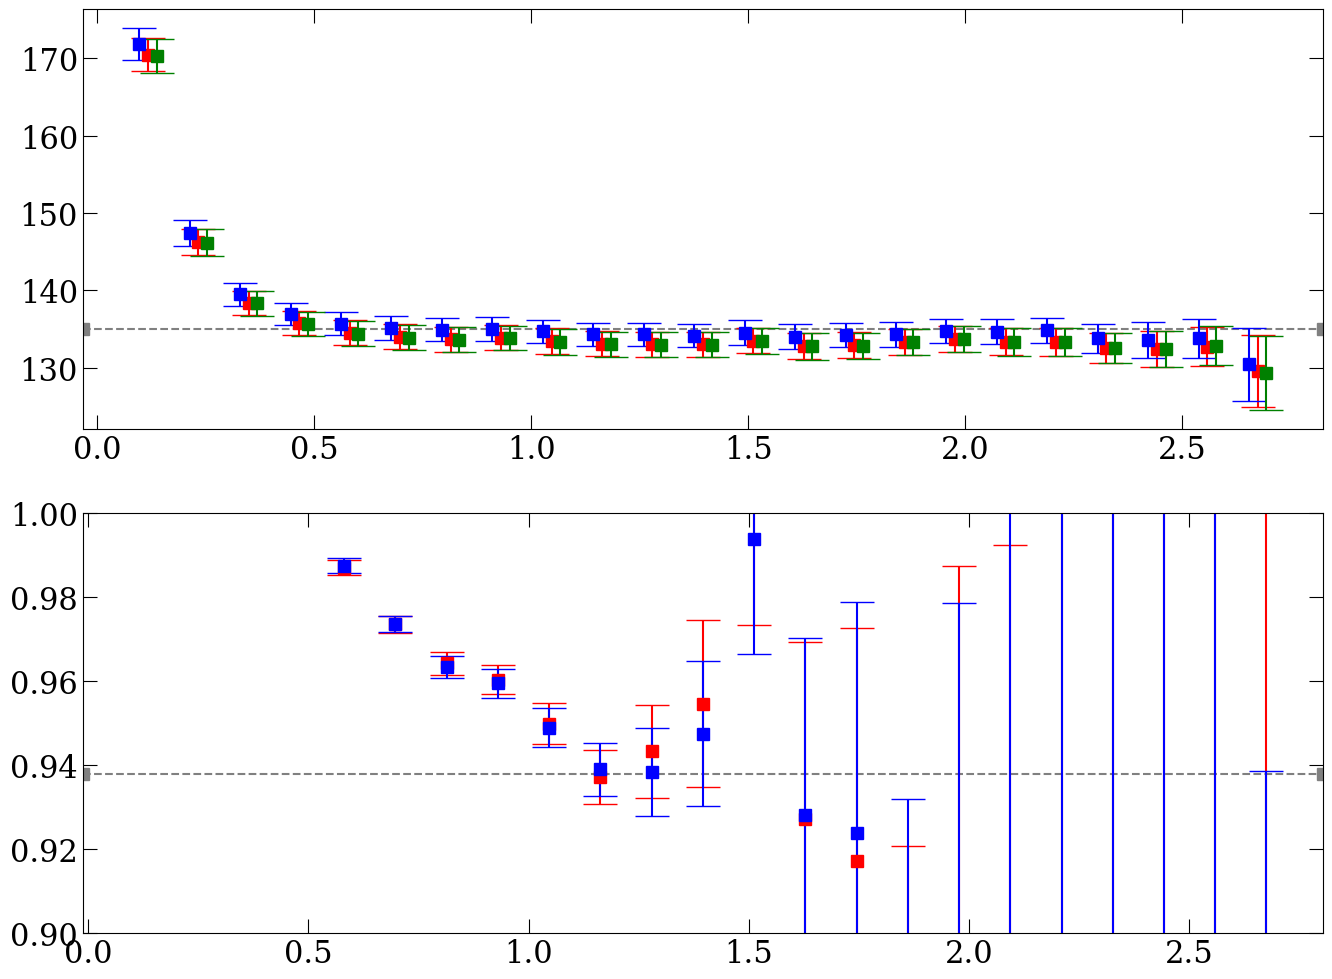

In [80]:
fig, axs = yu.getFigAxs(2,1,Lrow=6,Lcol=16)

ax=axs[0,0]
xunit=lat_a; yunit=lat_aInv
tmin=1; tmax=24
# ax.set_ylim([0.9,1.5])
ax.axhline(135,color='grey',ls='--')

mean,err=yu.jackme(mp)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

mean,err=yu.jackme(mps)
plt_x=np.arange(tmin,tmax)*xunit-0.02; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

mean,err=yu.jackme(mps2)
plt_x=np.arange(tmin,tmax)*xunit+0.02; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='g')

ax=axs[1,0]
xunit=lat_a; yunit=lat_aInv/1000
tmin=1; tmax=24
ax.set_ylim([0.9,1.0])
ax.axhline(0.938,color='grey',ls='--')

mean,err=yu.jackme(m2)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='r')

mean,err=yu.jackme(m2s)
plt_x=np.arange(tmin,tmax)*xunit; plt_y=mean[tmin:tmax]*yunit; plt_yerr=err[tmin:tmax]*yunit
ax.errorbar(plt_x,plt_y,plt_yerr,color='b')

In [9]:
i_start=50; i_end=50+2000
cfg2srcs={}
path='/capstor/store/cscs/userlab/s1174/lyan/code/glwc2/project2/03_NpiScatteringWilson/dataPrepare/A15/data_aux/srcs.h5'
with h5py.File(path) as f:
    for cfg in f.keys():        
        cfg2srcs[cfg]=f[cfg][i_start:i_end]

from random import shuffle

path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15/data_post/'
cfgs=os.listdir(path)
cfgs.sort()
data=[]
for i,cfg in enumerate(cfgs):
    print(i,len(cfgs),end='            \r')
    file=f'{path}{cfg}/N.h5_0mom'
    with h5py.File(file) as f:
        # srcs=list(f['data'].keys())
        # shuffle(srcs)
        srcs=['sx{:02d}sy{:02d}sz{:02d}st{:02d}'.format(sx,sy,sz,st) for sx,sy,sz,st in cfg2srcs[cfg]]
        
        def get(src):
            t=f['data'][src]['N_a'][:,16,:]
            t_bw=np.roll(np.flip(t,axis=1),1,axis=1)
            return ( (t[:,0]+t[:,5]) - (t_bw[:,10]+t_bw[:,15]) )/4
        
        t=[get(src) for src in srcs]
        data.append(t)
    # break
data=np.array(data)
print(data.shape)

path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15/data_merge/Nsrc=.h5'
with h5py.File(path,'w') as f:
    f.create_dataset('srcs',data=np.array([cfg2srcs[cfg] for cfg in cfgs]))
    f.create_dataset('N',data=data)

(211, 2000, 48)    


In [8]:
path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15/data_merge/Nsrc=1000.h5'
with h5py.File(path) as f:
    data=f['N'][:]
    
    t=[]
    for dat in data:
        inds=list(range(len(dat)))
        t.append(dat[inds])
    data=np.real(np.array(t))
    
    
t=data[:,:,1]
mean=np.mean(t)
std=np.sqrt(np.var(t,ddof=1))
# print(mean,std)
tt=(t-mean)/std

# plt.hist(tt,bins=1000)
# plt.xlim([-10,10])

# tt=[int(np.abs(ele)) for ele in tt]

# import collections
# counter = collections.Counter(tt)
# keys=list(counter.keys())
# keys.sort()
# for key in keys:
#     print(key,counter[key])

for i,row in enumerate(tt):
    for j,ele in enumerate(row):
        if abs(ele)>40:
            print(int(ele),i,j)
            # print(int(ele),i,cfgs[i],j,cfg2srcs[cfgs[i]][j])

117 8 220
59 8 349
57 72 273
87 84 749
45 119 835
52 146 244


In [7]:
path='/capstor/store/cscs/userlab/s1174/lyan/code/scratch/run/03_NpiScatteringWilson/A15/run/a0009/Diagram0009_sx019sy029sz040st043_N.h5'
with h5py.File(path) as f:
    t=f['sx19sy29sz40st43/N_a'][:,16,0]
    t=t[:,:,0]+1j*t[:,:,1]
    t_bw=np.roll(np.flip(t,axis=1),1,axis=1)
    t= ( (t[:,0]+t[:,5]) - (t_bw[:,10]+t_bw[:,15]) )/4
    t=np.real(t)
    print(t[1])
    print((t[1]-mean)/std)

3.726423e-06
117.508


In [10]:
from random import shuffle

path='/capstor/store/cscs/userlab/s1174/lyan/code/projectData2/03_NpiScatteringWilson/A15/data_merge/Nsrc=2000.h5'
with h5py.File(path) as f:
    data=f['N'][:]
    
    t=[]
    for dat in data:
        inds=list(range(len(dat)))
        shuffle(inds)
        t.append(dat[inds])
    data=np.real(np.array(t))

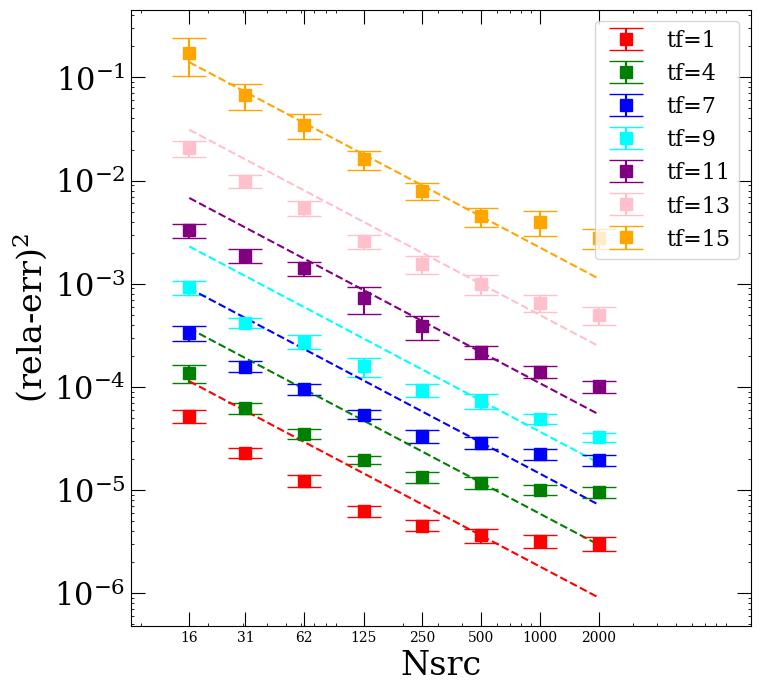

In [11]:
Nsrc_base=500
# Nsrcs=[1,2,4,8,16,32,64,125,250,500]
Nsrcs=[16,31,62,125,250,500,1000,2000]
tfs=[1,4,7,9,11,13,15]

fig, axs = yu.getFigAxs(1,1,Lrow=8,Lcol=8)
ax=axs[0,0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([Nsrcs[0]/2,Nsrcs[-1]*6])
ax.set_xticks(Nsrcs)
ax.set_xticklabels([str(Nsrc) for Nsrc in Nsrcs],size=10)
ax.set_xlabel('Nsrc',size=24)
ax.set_ylabel(f'(rela-err)$^2$',size=24)

# plt_x=np.sqrt(Nsrcs); plt_y=np.sqrt(Nsrcs)/np.sqrt(Nsrc_base)
# ax.plot(plt_x,plt_y,color='black',ls='--',marker='')

colors=['r','g','b','cyan','purple','pink','orange']
for Nsrc in Nsrcs:
    def func(dat):
        N=len(dat)
        # t_base=np.sqrt(np.var(np.mean(dat[:,:Nsrc_base,:],axis=1),axis=0,ddof=1)/N)
        mean=np.mean(np.mean(dat,axis=1),axis=0)
        err=np.sqrt(np.var(np.mean(dat[:,:Nsrc,:],axis=1),axis=0,ddof=1)/N)    
        return err**2/mean**2
    mean,err,cov=yu.jackknife2(data,func)
    
    if Nsrc==Nsrc_base:
        for i,tf in enumerate(tfs):
            plt_x=Nsrcs; plt_y=Nsrc_base/np.array(Nsrcs)*mean[0][tf]
            ax.plot(plt_x,plt_y,color=colors[i],ls='--',marker='')

    for i,tf in enumerate(tfs):
        plt_x=Nsrc; plt_y=mean[0][tf]; plt_yerr=err[0][tf]
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i],label=f'tf={tf}' if Nsrc==Nsrc_base else None)

ax.legend(fontsize=16)
plt.savefig('fig/c2pt_nucleon_scaling.pdf')

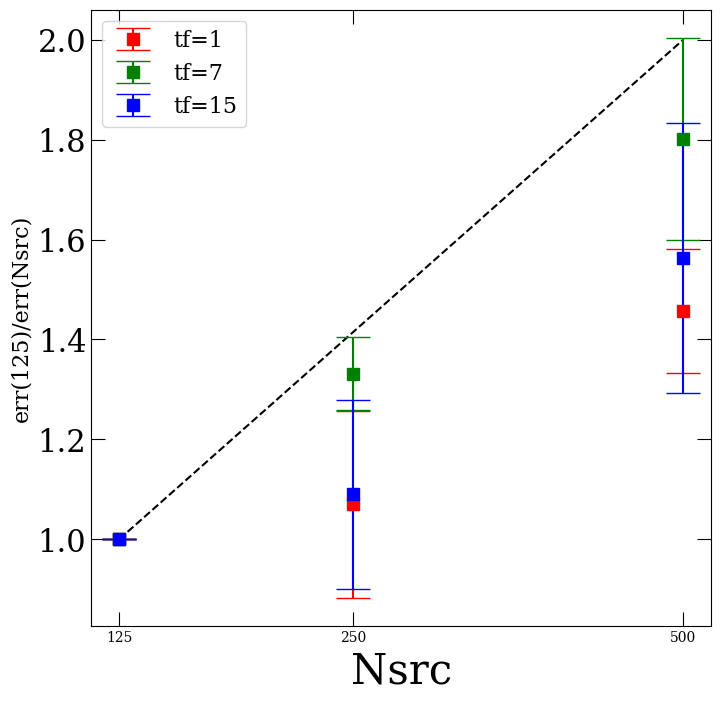

In [15]:
Nsrc_base=125
Nsrcs=[125,250,500]
tfs=[1,7,15]

fig, axs = yu.getFigAxs(1,1,Lrow=8,Lcol=8)
ax=axs[0,0]
ax.set_xticks(np.sqrt(Nsrcs))
ax.set_xticklabels(Nsrcs,size=10)
ax.set_xlabel('Nsrc')
ax.set_ylabel(f'err({Nsrc_base})/err(Nsrc)',size=16)

plt_x=np.sqrt(Nsrcs); plt_y=np.sqrt(Nsrcs)/np.sqrt(Nsrc_base)
ax.plot(plt_x,plt_y,color='black',ls='--',marker='')

colors=['r','g','b','cyan','purple','pink','orange']
for Nsrc in Nsrcs:
    def func(dat):
        N=len(dat)
        t_base=np.sqrt(np.var(np.mean(dat[:,:Nsrc_base,:],axis=1),axis=0,ddof=1)/N)
        t=np.sqrt(np.var(np.mean(dat[:,:Nsrc,:],axis=1),axis=0,ddof=1)/N)    
        t=t_base/t
        return t
    mean,err,cov=yu.jackknife2(data,func)
    
    for i,tf in enumerate(tfs):
        plt_x=np.sqrt(Nsrc); plt_y=mean[0][tf]; plt_yerr=err[0][tf]
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i],label=f'tf={tf}' if Nsrc==Nsrc_base else None)

ax.legend(fontsize=16)
    

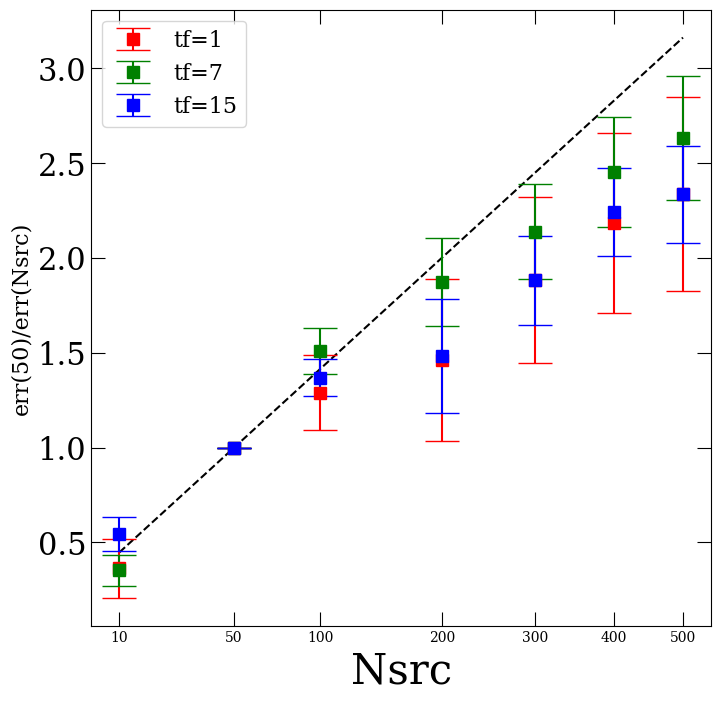

In [25]:
Nsrc_base=50
Nsrcs=[10,50,100,200,300,400,500]
tfs=[1,7,15]

fig, axs = yu.getFigAxs(1,1,Lrow=8,Lcol=8)
ax=axs[0,0]
ax.set_xticks(np.sqrt(Nsrcs))
ax.set_xticklabels(Nsrcs,size=10)
ax.set_xlabel('Nsrc')
ax.set_ylabel(f'err({Nsrc_base})/err(Nsrc)',size=16)

plt_x=np.sqrt(Nsrcs); plt_y=np.sqrt(Nsrcs)/np.sqrt(Nsrc_base)
ax.plot(plt_x,plt_y,color='black',ls='--',marker='')

colors=['r','g','b','cyan','purple','pink','orange']
for Nsrc in Nsrcs:
    def func(dat):
        N=len(dat)
        t_base=np.sqrt(np.var(np.mean(dat[:,:Nsrc_base,:],axis=1),axis=0,ddof=1)/N)
        t=np.sqrt(np.var(np.mean(dat[:,:Nsrc,:],axis=1),axis=0,ddof=1)/N)    
        t=t_base/t
        return t
    mean,err,cov=yu.jackknife2(data,func)
    
    for i,tf in enumerate(tfs):
        plt_x=np.sqrt(Nsrc); plt_y=mean[0][tf]; plt_yerr=err[0][tf]
        ax.errorbar(plt_x,plt_y,plt_yerr,color=colors[i],label=f'tf={tf}' if Nsrc==Nsrc_base else None)

ax.legend(fontsize=16)
    